In [102]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

main_experiments_path = "../experiments"
housing_experiment_path = "../../15_incremental_rbf_housing/experiments"

main_experiments = []


method_names = [
    "svr",
    "pls",
    "gradboost",
    "mlp_0.01",
    "mlp_0.001",
    "mlp_0.0001",
    "rbf_full_0.01",
    "rbf_full_0.001",
    "rbf_full_0.0001",
    "rbf_diag_0.01",
    "rbf_diag_0.001",
    "rbf_diag_0.0001",
    "rbf_scal_0.01",
    "rbf_scal_0.001",
    "rbf_scal_0.0001",
    "rbf_univ_0.01",
    "rbf_univ_0.001",
    "rbf_univ_0.0001",
    "ffn_0.1_0.01",
    "ffn_0.1_0.001",
    "ffn_0.1_0.0001",
    "ffn_1_0.01",
    "ffn_1_0.001",
    "ffn_1_0.0001",
    "ffn_10_0.01",
    "ffn_10_0.001",
    "ffn_10_0.0001",
    "uffn_0.1_0.01",
    "uffn_0.1_0.001",
    "uffn_0.1_0.0001",
    "uffn_1_0.01",
    "uffn_1_0.001",
    "uffn_1_0.0001",
    "uffn_10_0.01",
    "uffn_10_0.001",
    "uffn_10_0.0001",
]


condensed_method_names = [
    "svr",
    "pls",
    "gradboost",
    "mlp",
    "rbf_full",
    "rbf_diag",
    "rbf_scal",
    "rbf_univ",
    "ffn",
    "uffn",
]


repetition_ids = list(range(8))
learning_rates = ["0.01", "0.001", "0.0001"]
datasets = []
experiments_data = None

method_settings = os.listdir(main_experiments_path)

# sort by name
method_settings = sorted(method_settings)

#print all folders in the main experiments path
for method_folder in method_settings:
    # iterate over repetitions

    if method_folder.startswith("."):
        continue

    for repetition_folder in os.listdir(main_experiments_path + "/" + method_folder):
        # iterate over files

        if repetition_folder.startswith("."):
            continue

        ## add this repetition to the experiment df as column

        dataset_folders = os.listdir(main_experiments_path + "/" + method_folder + "/" + repetition_folder)
        ## sort the dataset folders by name
        dataset_folders = sorted(dataset_folders)
        dataset_folders = [dataset_folder for dataset_folder in dataset_folders if not dataset_folder.startswith(".") and dataset_folder != "data" and "data" in dataset_folder] 

        if experiments_data is None:
            datasets = [*dataset_folders, "housing"]
            datasets = [dataset.replace("data", "") for dataset in datasets]
            experiments_data = xr.DataArray(np.zeros((len(datasets),len(condensed_method_names), len(repetition_ids), len(learning_rates))) - 1, coords=[datasets, condensed_method_names, repetition_ids, learning_rates], dims=['datasets','method', 'repetition','lr'])


        for dataset_folder in dataset_folders:
            ## add this dataset to the experiments data array if it is not already there

            try:
                ## read the npy file
                train_loss = np.load(main_experiments_path + "/" + method_folder + "/" + repetition_folder + "/" + dataset_folder+ "/" + "train_loss.npy")
                val_loss = np.load(main_experiments_path + "/" + method_folder + "/" + repetition_folder + "/" + dataset_folder + "/" + "val_loss.npy")
                test_loss = np.load(main_experiments_path + "/" + method_folder + "/" + repetition_folder + "/" + dataset_folder + "/" + "test_loss.npy")
            except Exception as e:
                print("Error reading files for dataset: ", dataset_folder, e)
                continue
            
            ### extract the min val loss and pick the corresponding test loss

            min_val_loss = np.min(val_loss)
            min_val_loss_index = np.argmin(val_loss)

            min_test_loss = test_loss[min_val_loss_index]

            print(method_folder)
            method_folder_id = int(method_folder.split("_")[1])

            method_description = method_names[method_folder_id - 1]
            method_parts = method_description.split("_")

            #data_dim = int(method_parts[0])
            method_name = method_parts[0]

            repetition_id = int(repetition_folder.split("_")[1])

            if method_name == "rbf":
                method_name = method_name + "_" + method_parts[1]

            dataset_name = dataset_folder.replace("data", "")

            if len(method_parts) == 1:
                experiments_data.loc[dataset_name, method_name, repetition_id, :] = min_test_loss
            else:
                lr = method_parts[-1]
                experiments_data.loc[dataset_name, method_name, repetition_id, lr] = min_test_loss



method_settings = os.listdir(housing_experiment_path)

# exclude folders beginning with . (e.g. .DS_Store)
method_settings = [method_setting for method_setting in method_settings if not method_setting.startswith(".")]

# sort by name
method_settings = sorted(method_settings)

#print all folders in the main experiments path
for method_folder in method_settings:
    # iterate over repetitions

    if method_folder.startswith("."):
        continue

    for repetition_folder in os.listdir(housing_experiment_path + "/" + method_folder):

        ## exclude folders beginning with . (e.g. .DS_Store)
        if repetition_folder.startswith("."):
            continue

        # iterate over files

        dataset_folders = os.listdir(housing_experiment_path + "/" + method_folder + "/" + repetition_folder)

        ## sort the dataset folders by name
        dataset_folders = sorted(dataset_folders)

        dataset_folder = "data"
        dataset_name = "housing"

        try:
            ## read the npy file
            train_loss = np.load(housing_experiment_path + "/" + method_folder + "/" + repetition_folder + "/" + dataset_folder+ "/" + "train_loss.npy")
            val_loss = np.load(housing_experiment_path + "/" + method_folder + "/" + repetition_folder + "/" + dataset_folder + "/" + "val_loss.npy")
            test_loss = np.load(housing_experiment_path + "/" + method_folder + "/" + repetition_folder + "/" + dataset_folder + "/" + "test_loss.npy")
        except Exception as e:
            print("Error reading files for dataset: ", dataset_name, e)
            continue

        ### extract the min val loss and pick the corresponding test loss
        min_val_loss = np.min(val_loss)
        min_val_loss_index = np.argmin(val_loss)

        min_test_loss = test_loss[min_val_loss_index]

        method_folder_id = int(method_folder.split("_")[1])

        method_description = method_names[method_folder_id - 1]
        method_parts = method_description.split("_")

        method_name = method_parts[0]

        repetition_id = int(repetition_folder.split("_")[1])

        if method_name == "rbf":
            method_name = method_name + "_" + method_parts[1]

        if len(method_parts) == 1:
            experiments_data.loc[dataset_name, method_name, repetition_id, :] = min_test_loss
        else:
            lr = method_parts[-1]
            experiments_data.loc[dataset_name, method_name, repetition_id, lr] = min_test_loss


experiments_data = experiments_data.sortby("datasets")

experiments_data

experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment_000001
experiment

<xarray.DataArray (datasets: 20, method: 10, repetition: 8, lr: 3)> Size: 38kB
array([[[[3.48298303e-01, 3.48298303e-01, 3.48298303e-01],
         [3.03191444e-01, 3.03191444e-01, 3.03191444e-01],
         [3.53749366e-01, 3.53749366e-01, 3.53749366e-01],
         ...,
         [2.57550246e-01, 2.57550246e-01, 2.57550246e-01],
         [3.23077170e-01, 3.23077170e-01, 3.23077170e-01],
         [3.51112214e-01, 3.51112214e-01, 3.51112214e-01]],

        [[2.28858337e-01, 2.28858337e-01, 2.28858337e-01],
         [3.62206544e-01, 3.62206544e-01, 3.62206544e-01],
         [3.49747050e-01, 3.49747050e-01, 3.49747050e-01],
         ...,
         [2.36508160e-01, 2.36508160e-01, 2.36508160e-01],
         [2.67840446e-01, 2.67840446e-01, 2.67840446e-01],
         [2.88927952e-01, 2.88927952e-01, 2.88927952e-01]],

        [[3.28399476e-01, 3.28399476e-01, 3.28399476e-01],
         [3.65380730e-01, 3.65380730e-01, 3.65380730e-01],
         [3.69257701e-01, 3.69257701e-01, 3.69257701e-01],
         ...,
...
         ...,
         [1.76420364e-01, 1.43159500e-01, 2.25225091e-01],
         [1.89723579e-01, 1.64563258e-01, 2.34912405e-01],
         [2.09080823e-01, 1.83214170e-01, 2.00916773e-01]],

        [[9.40565836e-01, 9.48261872e-01, 9.47043799e-01],
         [9.23091374e-01, 9.22846440e-01, 9.28200997e-01],
         [9.76256832e-01, 9.80156902e-01, 9.72829144e-01],
         ...,
         [9.36576985e-01, 9.23287380e-01, 9.31982175e-01],
         [9.56838250e-01, 9.70065780e-01, 9.78940733e-01],
         [9.47624300e-01, 9.45222575e-01, 9.50236794e-01]],

        [[2.03174181e-01, 2.10689060e-01, 2.11118760e-01],
         [2.09421870e-01, 2.04456137e-01, 1.86774475e-01],
         [2.08313361e-01, 2.13533591e-01, 2.10778622e-01],
         ...,
         [2.21563073e-01, 2.20048727e-01, 2.19830008e-01],
         [1.74249401e-01, 1.83870916e-01, 1.73734506e-01],
         [2.49176377e-01, 2.39389223e-01, 2.57239890e-01]]]])
Coordinates:
  * datasets    (datasets) <U29 2kB '1027_ESL' '1029_LEV' ... 'banana' 'housing'
  * method      (method) <U9 360B 'svr' 'pls' 'gradboost' ... 'ffn' 'uffn'
  * repetition  (repetition) int64 64B 0 1 2 3 4 5 6 7
  * lr          (lr) <U6 72B '0.01' '0.001' '0.0001'

In [103]:
_experiments_data = experiments_data.copy()


repetition_datasets_mean_data = _experiments_data.mean(dim=['datasets', 'repetition'])

## normalize the data by the mlp mean

min_mlp_mean = repetition_datasets_mean_data.sel(dict(method="mlp")).min()
repetition_datasets_mean_data = repetition_datasets_mean_data / min_mlp_mean
_experiments_data = _experiments_data / min_mlp_mean


repetition_datasets_std_data = _experiments_data.std(dim=['datasets', 'repetition'])

repetition_dim_summary_data = xr.concat([repetition_datasets_mean_data, repetition_datasets_std_data], dim= pd.Index(["mean", "std"], name='summary'))

means = repetition_dim_summary_data.sel(summary="mean")
min_mean_index = means.argmin(dim="lr")
min_mean_index = min_mean_index.drop_vars('summary')
min_mean_index = min_mean_index.squeeze()

collapsed_repetition_datasets_summary_data = repetition_dim_summary_data.isel(lr=min_mean_index, missing_dims="ignore")
collapsed_repetition_datasets_summary_data = collapsed_repetition_datasets_summary_data.drop_vars('lr')

collapsed_repetition_datasets_summary_data



<xarray.DataArray (summary: 2, method: 10)> Size: 160B
array([[ 4.03176292,  3.73973839,  0.52850495,  1.        ,  0.69184172,
         0.69184172,  3.68135485,  0.56623875,  3.79624451,  0.66270413],
       [20.68955466, 18.95531158,  2.76335186,  5.79073615,  3.37969724,
         3.37969724, 19.11279724,  2.92647589, 19.37165376,  3.36045435]])
Coordinates:
  * method   (method) <U9 360B 'svr' 'pls' 'gradboost' ... 'ffn' 'uffn'
  * summary  (summary) object 16B 'mean' 'std'

In [104]:
_experiments_data = experiments_data.copy()

### average over repetitions and pick the min value across learning rates
repetition_mean_data = _experiments_data.mean(dim='repetition')
min_mlp_mean = repetition_mean_data.sel(dict(method="mlp")).min(dim='lr')

print("min mlp ",min_mlp_mean.shape, "min mlp", min_mlp_mean)
repetition_mean_data = repetition_mean_data / min_mlp_mean

_experiments_data = _experiments_data / min_mlp_mean 
repetition_std_data = _experiments_data.std(dim='repetition')

## combine mean and std into one xarray

repetition_summary_data = xr.concat([repetition_mean_data, repetition_std_data], dim= pd.Index(["mean", "std"], name='summary'))

### now keep the min mean value across learning rates for each method and data dimension combination and also keep the corresponding std value 
#min_mean_lr = repetition_summary_data.loc[dict(summary='mean')].argmin(dim='lr')

means = repetition_summary_data.sel(summary="mean")
min_mean_index = means.argmin(dim="lr")

min_mean_index = min_mean_index.drop_vars('summary')

min_mean_index = min_mean_index.squeeze()

collapsed_repetition_summary_data = repetition_summary_data.isel(lr=min_mean_index, missing_dims="ignore")
collapsed_repetition_summary_data = collapsed_repetition_summary_data.drop_vars('lr')
collapsed_repetition_summary_data

min mlp  (20,) min mlp <xarray.DataArray (datasets: 20)> Size: 160B
array([2.86590995e-01, 7.33001795e-01, 5.14709380e+00, 3.92013711e+00,
       9.68640381e+00, 2.04086761e-01, 1.56340895e+02, 3.37324695e+04,
       2.30656621e+00, 1.16255878e+00, 1.32691063e+01, 2.63824112e+06,
       9.05733728e-02, 6.01775607e+00, 1.16301638e+01, 1.07478948e+02,
       7.91430180e+02, 3.98370852e+01, 5.98384442e-01, 1.79622292e-01])
Coordinates:
  * datasets  (datasets) <U29 2kB '1027_ESL' '1029_LEV' ... 'banana' 'housing'
    method    <U9 36B 'mlp'


<xarray.DataArray (summary: 2, datasets: 20, method: 10)> Size: 3kB
array([[[1.11808025e+00, 9.73209850e-01, 1.13994173e+00, 1.00000000e+00,
         9.69668743e-01, 9.69668743e-01, 9.54457656e-01, 1.08672259e+00,
         6.13154376e+00, 1.20450303e+00],
        [5.20332418e-01, 5.10637029e-01, 5.37392795e-01, 1.00000000e+00,
         1.02275101e+00, 1.02275101e+00, 1.01793547e+00, 1.02537955e+00,
         1.18925676e+00, 1.02104234e+00],
        [5.24513761e-01, 5.05923374e-01, 5.32319587e-01, 1.00000000e+00,
         1.00446771e+00, 1.00446771e+00, 1.01689932e+00, 1.04444995e+00,
         1.08032683e+00, 1.06401744e+00],
        [4.77289215e+00, 4.49660948e+00, 1.79660541e+00, 1.00000000e+00,
         1.25262038e+00, 1.25262038e+00, 1.22622216e+00, 1.17679510e+00,
         1.15875896e+01, 8.17824918e+00],
        [9.11292880e-01, 8.74430982e-01, 1.17224704e+00, 1.00000000e+00,
         2.24351931e+00, 2.24351931e+00, 2.25533032e+00, 8.09359842e-01,
         2.48839492e+00, 1.96440136e+00],
        [1.64774861e+00, 8.67298996e-01, 1.19588217e+00, 1.00000000e+00,
         1.14087336e+00, 1.14087336e+00, 1.20251681e+00, 1.08075850e+00,
         5.97585084e+00, 5.54887648e+00],
        [3.04574409e+00, 9.95961430e-01, 1.33436556e+00, 1.00000000e+00,
         9.38627371e-01, 9.38627371e-01, 1.12217836e+00, 8.66301018e-01,
...
         4.27632856e+00, 4.27632856e+00, 5.32884128e+00, 2.30453862e-01,
         7.47370085e+01, 6.57349828e+00],
        [2.10176889e-01, 1.65219873e-01, 1.61004064e-01, 2.65973573e-01,
         3.48657978e-01, 3.48657978e-01, 3.51024071e-01, 1.60432254e-01,
         1.56028655e-01, 2.01564748e-01],
        [3.49027591e-01, 2.50087395e-01, 5.60472891e-01, 2.79426962e-01,
         2.85639513e-01, 2.85639513e-01, 2.89048375e-01, 3.11784416e-01,
         8.56487241e-01, 1.12165755e+00],
        [7.72961121e-01, 1.78911724e-01, 6.34837282e-02, 6.48078458e-01,
         6.39076801e-02, 6.39076801e-02, 1.22732282e+00, 6.20442738e-02,
         7.66359147e+00, 6.46293421e+00],
        [7.71441271e-01, 1.16808097e-01, 2.00811592e-01, 1.31595115e-01,
         2.30477494e+01, 2.30477494e+01, 1.72670579e-01, 1.61666404e-01,
         7.32312394e-01, 1.36238227e+00],
        [5.50709065e-03, 2.16419884e-03, 5.31382953e-03, 7.23490029e-02,
         6.38026978e-02, 6.38026978e-02, 5.21292143e-02, 7.92013928e-02,
         1.35981751e-01, 6.90160210e-01],
        [3.37738304e-03, 7.05603591e-01, 3.11546804e-03, 1.47227113e-01,
         1.35471639e+00, 1.34811559e+00, 1.28661028e+00, 8.06656221e-02,
         8.55384728e-02, 1.35067912e-01]]])
Coordinates:
  * datasets  (datasets) <U29 2kB '1027_ESL' '1029_LEV' ... 'banana' 'housing'
  * method    (method) <U9 360B 'svr' 'pls' 'gradboost' ... 'ffn' 'uffn'
  * summary   (summary) object 16B 'mean' 'std'

In [105]:
method_renaming = {
    "svr": "SVR",
    "gradboost": "GradBoost",
    "mlp": "MLP",
    "rbf_full": "RBF Full",
    "rbf_diag": "RBF Diag",
    "rbf_scal": "RBF Scal",
    "rbf_univ": "U-RBF",
    "ffn": "FFM",
    "uffn": "U-FFM",
}

### rename the method coords and only keep the methods that have a mapping

collapsed_repetition_summary_data = collapsed_repetition_summary_data.sel(dict(method=[key for key in method_renaming.keys() if key in collapsed_repetition_summary_data.method.values]))#.sel(method=[key for key in method_renaming.keys() if key in method_renaming.keys()])
collapsed_repetition_summary_data.coords['method'] = [method_renaming[method] for method in collapsed_repetition_summary_data.method.values]


mean_summary_data = collapsed_repetition_summary_data.sel(summary="mean")
std_summary_data = collapsed_repetition_summary_data.sel(summary="std") 



mean_df = mean_summary_data.to_dataframe(name='value').reset_index()
mean_df = mean_df.pivot_table(index='datasets', columns='method', values='value', aggfunc=lambda x: list(x)[0])

std_df = std_summary_data.to_dataframe(name='value').reset_index()
std_df = std_df.pivot_table(index='datasets', columns='method', values='value', aggfunc=lambda x: list(x)[0])


## rename the row index 
mean_df.index = [str(dim) + " m"  for dim in mean_df.index]

std_df.index = [str(dim) + " s"  for dim in std_df.index]


### merge the mean and std dataframes into one and alternate the rows

final_df = pd.concat([mean_df, std_df], axis=0)
final_df = final_df.sort_index()

### add the average row at the end

collapsed_repetition_datasets_summary_data = collapsed_repetition_datasets_summary_data.sel(dict(method=[key for key in method_renaming.keys() if key in collapsed_repetition_datasets_summary_data.method.values]))#.sel(method=[key for key in method_renaming.keys() if key in method_renaming.keys()])
collapsed_repetition_datasets_summary_data.coords['method'] = [method_renaming[method] for method in collapsed_repetition_datasets_summary_data.method.values]

mean_datasets_summary_data = collapsed_repetition_datasets_summary_data.sel(summary="mean")
std_datasets_summary_data = collapsed_repetition_datasets_summary_data.sel(summary="std")

mean_datasets_summary_data = mean_datasets_summary_data.to_dataframe(name='value').reset_index()
mean_datasets_summary_data = mean_datasets_summary_data.pivot_table( columns='method', values='value', aggfunc=lambda x: list(x)[0])

std_datasets_summary_data = std_datasets_summary_data.to_dataframe(name='value').reset_index()
std_datasets_summary_data = std_datasets_summary_data.pivot_table( columns='method', values='value', aggfunc=lambda x: list(x)[0])


## rename the row index
mean_datasets_summary_data.index = [str(dim) + " m"  for dim in mean_datasets_summary_data.index]

std_datasets_summary_data.index = [str(dim) + " s"  for dim in std_datasets_summary_data.index]


final_datasets_summary_df = pd.concat([mean_datasets_summary_data, std_datasets_summary_data], axis=0)
final_datasets_summary_df = final_datasets_summary_df.sort_index()

final_df = pd.concat([final_df, final_datasets_summary_df], axis=0)

final_df

method,FFM,GradBoost,MLP,RBF Diag,RBF Full,RBF Scal,SVR,U-FFM,U-RBF
1027_ESL m,6.131544,1.139942,1.000000,0.969669,0.969669,0.954458,1.118080,1.204503,1.086723
1027_ESL s,1.784650,0.114022,0.182500,0.110322,0.110322,0.093244,0.112047,0.228427,0.186803
1029_LEV m,1.189257,0.537393,1.000000,1.022751,1.022751,1.017935,0.520332,1.021042,1.025380
1029_LEV s,0.135301,0.068134,0.100182,0.125691,0.125691,0.106225,0.076944,0.129986,0.103018
1030_ERA m,1.080327,0.532320,1.000000,1.004468,1.004468,1.016899,0.524514,1.064017,1.044450
1030_ERA s,0.106781,0.057138,0.099749,0.094676,0.094676,0.096931,0.048284,0.124041,0.104099
1096_FacultySalaries m,11.587590,1.796605,1.000000,1.252620,1.252620,1.226222,4.772892,8.178249,1.176795
1096_FacultySalaries s,4.180500,0.603406,0.254442,0.544230,0.544230,0.623987,0.895344,2.059780,0.419599
192_vineyard m,2.488395,1.172247,1.000000,2.243519,2.243519,2.255330,0.911293,1.964401,0.809360
192_vineyard s,1.066490,0.482676,0.392913,3.469164,3.469164,3.463639,0.728675,1.957403,0.270771


Coordinates:
  * summary  (summary) object 16B 'mean' 'std'
  * method   (method) <U9 324B 'SVR' 'GradBoost' 'MLP' ... 'U-RBF' 'FFM' 'U-FFM'
              value
method             
FFM        3.796245
GradBoost  0.528505
MLP        1.000000
RBF Diag   0.691842
RBF Full   0.691842
RBF Scal   3.681355
SVR        4.031763
U-FFM      0.662704
U-RBF      0.566239


/var/folders/vx/2hn3fq3j01ndcrt24ck57sr80000gn/T/ipykernel_83293/3159433786.py:34: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bottom=0)


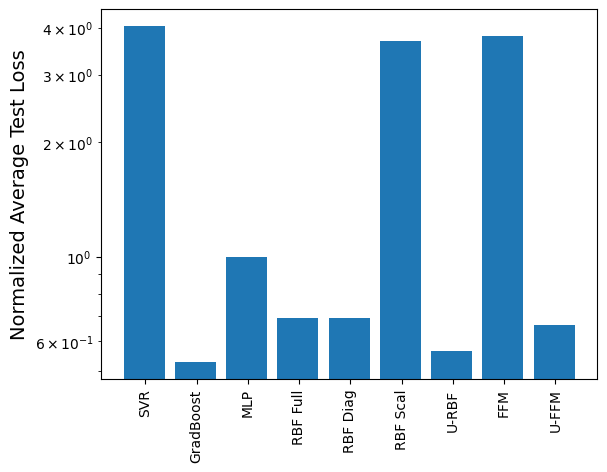

In [106]:
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

print(collapsed_repetition_datasets_summary_data.coords)


mean_repetition_datasets_df = collapsed_repetition_datasets_summary_data.sel(summary="mean").to_dataframe(name='value').reset_index()
mean_repetition_datasets_df = mean_repetition_datasets_df.pivot_table(index='method',  values='value', aggfunc=lambda x: list(x)[0])
#mean_repetition_datasets_df = mean_repetition_datasets_df.drop("pls")

print(mean_repetition_datasets_df)

mean_repetition_datasets_df = mean_repetition_datasets_df.rename(index=method_renaming)
## sort the index by the order in the method names list
mean_repetition_datasets_df = mean_repetition_datasets_df.reindex(method_renaming.values())


## normalize the data by the mlp value

mean_repetition_datasets_df = mean_repetition_datasets_df / mean_repetition_datasets_df.loc["MLP"]


for i, method in enumerate(mean_repetition_datasets_df.columns):

    plt.bar(x + i*bar_width, mean_repetition_datasets_df[method], label=method, color=colors[i])


plt.xticks(x + (len(mean_repetition_datasets_df.columns)/2)*bar_width, mean_repetition_datasets_df.index, rotation=90)

#plt.bar(df.index, df,  color=colors)

plt.xticks(rotation=90)
plt.ylabel("Normalized Average Test Loss",fontsize=14)
plt.yscale("log")
plt.ylim(bottom=0)

plt.show()



In [107]:
### create a latex table for the mean and std values for the datasets and for the average across datasets

## 

repetition_datasets_df = collapsed_repetition_datasets_summary_data.to_dataframe(name='value').reset_index() 


### remove the pls method
repetition_datasets_df = repetition_datasets_df[repetition_datasets_df.method != "pls"]
### perform the renaming
repetition_datasets_df['method'] = repetition_datasets_df['method'].map(method_renaming)

print(repetition_datasets_df)

## the methods are on the columns and the mean / std values are on the rows

repetition_datasets_df = repetition_datasets_df.pivot_table(index='summary', columns='method', values='value', aggfunc=lambda x: list(x)[0])


print(repetition_datasets_df.to_latex(float_format="%.2f"))

   summary method      value
0     mean    NaN   4.031763
1     mean    NaN   0.528505
2     mean    NaN   1.000000
3     mean    NaN   0.691842
4     mean    NaN   0.691842
5     mean    NaN   3.681355
6     mean    NaN   0.566239
7     mean    NaN   3.796245
8     mean    NaN   0.662704
9      std    NaN  20.689555
10     std    NaN   2.763352
11     std    NaN   5.790736
12     std    NaN   3.379697
13     std    NaN   3.379697
14     std    NaN  19.112797
15     std    NaN   2.926476
16     std    NaN  19.371654
17     std    NaN   3.360454
\begin{tabular}{l}
\toprule
summary \\
\midrule
\bottomrule
\end{tabular}



In [108]:
## visualize the results using matplotlib using a log scale and multiple bars per dataset 

import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))

bar_width = 0.05
x = np.arange(len(condensed_experiments_df.index))

for i, method in enumerate(condensed_experiments_df.columns):
    plt.bar(x + i*bar_width, condensed_experiments_df[method], width=bar_width, label=method)

plt.xticks(x + (len(condensed_experiments_df.columns)/2)*bar_width, condensed_experiments_df.index, rotation=90)

plt.yscale("log")
plt.legend(condensed_experiments_df.columns)
plt.show()



NameError: name 'condensed_experiments_df' is not defined

<Figure size 2000x1000 with 0 Axes>

In [ ]:
### normalize the results by the mlp result for each dataset

normalized_experiments_df = condensed_experiments_df.copy()

for dataset_folder in normalized_experiments_df.index:
    mlp_result = normalized_experiments_df.loc[dataset_folder, "mlp"]
    normalized_experiments_df.loc[dataset_folder] = normalized_experiments_df.loc[dataset_folder] / mlp_result



/var/folders/vx/2hn3fq3j01ndcrt24ck57sr80000gn/T/ipykernel_81235/610936051.py:33: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bottom=0)


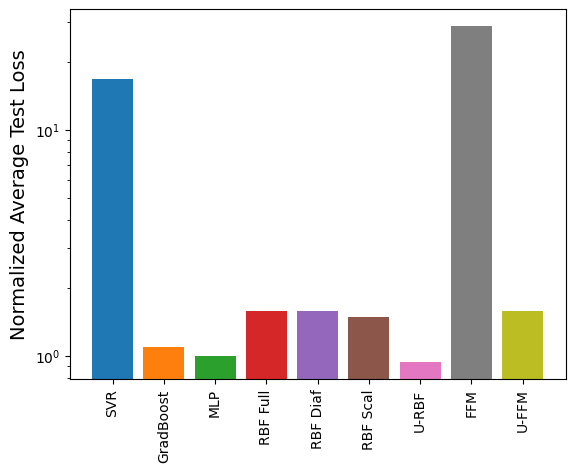

In [ ]:
### calculate an average across all datasets for each method and visualize the results

average_across_datasets = normalized_experiments_df.mean(axis=0)


method_renaming = {
    "svr": "SVR",
    #"pls": "PLS",
    "gradboost": "GradBoost",
    "mlp": "MLP",
    "rbf_full": "RBF Full",
    "rbf_diag": "RBF Diaf",
    "rbf_scal": "RBF Scal",
    "rbf_univ": "U-RBF",
    "ffn": "FFM",
    "uffn": "U-FFM",
}

## rename the methods and exclude methods whose names are not in the method_renaming dict

average_across_datasets = average_across_datasets[average_across_datasets.index.isin(method_renaming.keys())]
average_across_datasets = average_across_datasets.rename(index=method_renaming)

## color the bars

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

#plt.figure(figsize=(20,10))
plt.bar(average_across_datasets.index, average_across_datasets, color=colors)
plt.xticks(rotation=90)
plt.ylabel("Normalized Average Test Loss",fontsize=14)
plt.yscale("log")
plt.ylim(bottom=0)

plt.savefig("../../../assets/full_dataset_results.pdf", format="pdf", bbox_inches='tight')




plt.show()




In [ ]:
import exputils as eu
import numpy as np
import matplotlib.pyplot as plt
from function_regression.datasets.pmlb_dataset import PMLBDataset


dataset_names = normalized_experiments_df.index

dataset_info = []

for dataset_name in dataset_names:
    config = eu.AttrDict()
    config.name = dataset_name[4:]

    dataset_folder = PMLBDataset(config)
    
    x, y = dataset_folder.generate_samples()
    

    # Assuming dataset has attributes or methods to get input dimension and sample size
    input_dim = len(x[0])  # Example: input dimension could be derived from the shape of x
    sample_size = len(x)  # Example: sample size could be the length of x

    dataset_info.append((input_dim, sample_size, dataset_name))

        



fetching: 1027_ESL
Sampled X:(488, 4) Y:(488, 1) from 1027_ESL
fetching: 1029_LEV
Sampled X:(1000, 4) Y:(1000, 1) from 1029_LEV
fetching: 1030_ERA
Sampled X:(1000, 4) Y:(1000, 1) from 1030_ERA
fetching: 1096_FacultySalaries
Sampled X:(50, 4) Y:(50, 1) from 1096_FacultySalaries
fetching: 192_vineyard
Sampled X:(52, 2) Y:(52, 1) from 192_vineyard
fetching: 210_cloud
Sampled X:(108, 5) Y:(108, 1) from 210_cloud
fetching: 228_elusage
Sampled X:(55, 2) Y:(55, 1) from 228_elusage
fetching: 485_analcatdata_vehicle
Sampled X:(48, 4) Y:(48, 1) from 485_analcatdata_vehicle
fetching: 519_vinnie
Sampled X:(380, 2) Y:(380, 1) from 519_vinnie
fetching: 523_analcatdata_neavote
Sampled X:(100, 2) Y:(100, 1) from 523_analcatdata_neavote
fetching: 529_pollen
Sampled X:(3848, 4) Y:(3848, 1) from 529_pollen
fetching: 556_analcatdata_apnea2
Sampled X:(475, 3) Y:(475, 1) from 556_analcatdata_apnea2
fetching: 579_fri_c0_250_5
Sampled X:(250, 5) Y:(250, 1) from 579_fri_c0_250_5
fetching: 663_rabe_266
Sampled 

In [ ]:

# Convert dataset information to a format suitable for Plotly
input_dims, sample_sizes, dataset_names = zip(*dataset_info)

### based on the input dimensions calculate the mean test loss for each method and input dimension
results_per_dimension_df_mean = pd.DataFrame()
results_per_dimension_df_std = pd.DataFrame()

for dim in set(input_dims):

    ## get the list of datasets with this dimension
    datasets_with_dim = [dataset for dataset, input_dim in zip(dataset_names, input_dims) if input_dim == dim]

    ## get a subset of the normalized experiments df with only these datasets
    subset_mean = normalized_experiments_df.loc[datasets_with_dim].mean()
    subset_std = normalized_experiments_df.loc[datasets_with_dim].std()

    results_per_dimension_df_mean[dim] = subset_mean
    results_per_dimension_df_std[dim] = subset_std

results_per_dimension_df_mean = results_per_dimension_df_mean.T
results_per_dimension_df_std = results_per_dimension_df_std.T


## convert the results to latex table and highlight the best result in each row also show the std in brackets after the each mean value
#results_per_dimension_df_mean = results_per_dimension_df_mean.applymap(lambda x: "{:.2f}".format(x))
#results_per_dimension_df_mean = results_per_dimension_df_mean.apply(lambda x: x.apply(lambda y: "\\textbf{" + y + "}" if y == min(x) else y), axis=1)


results_per_dimension_df_mean = results_per_dimension_df_mean.applymap(lambda x: "{:.2f}".format(x))
results_per_dimension_df_std = results_per_dimension_df_std.applymap(lambda x: " (±{:.2f})".format(x))


results_per_dimension_df_mean = results_per_dimension_df_mean + results_per_dimension_df_std

results_per_dimension_df_mean = results_per_dimension_df_mean.apply(lambda x: x.apply(lambda y: "\\textbf{" + y + "}" if y == min(x) else y), axis=1)

## remove pls column
results_per_dimension_df_mean = results_per_dimension_df_mean.drop(columns="pls")

## print as latex table
print(results_per_dimension_df_mean.to_latex())
results_per_dimension_df_mean



    

\begin{tabular}{llllllllll}
\toprule
 & svr & gradboost & mlp & rbf_full & rbf_diag & rbf_scal & rbf_univ & ffn & uffn \\
\midrule
2 & 41.60 (±104.31) & 1.34 (±0.75) & 1.00 (±0.00) & 2.62 (±3.14) & 2.62 (±3.14) & 1.63 (±0.98) & \textbf{0.87 (±0.21)} & 68.60 (±177.28) & 1.38 (±0.66) \\
3 & 2.41 (±2.33) & 0.73 (±0.29) & 1.00 (±0.00) & 0.82 (±0.18) & 0.82 (±0.18) & 2.27 (±2.05) & \textbf{0.67 (±0.16)} & 2.44 (±1.93) & 0.80 (±0.29) \\
4 & 2.54 (±3.00) & \textbf{0.77 (±0.56)} & 1.00 (±0.00) & 0.95 (±0.28) & 0.95 (±0.28) & 1.22 (±0.30) & 0.98 (±0.24) & 7.67 (±11.98) & 2.06 (±1.77) \\
5 & 1.67 (±0.27) & 1.52 (±0.64) & \textbf{1.00 (±0.00)} & 1.17 (±0.22) & 1.17 (±0.22) & 1.22 (±0.10) & 1.19 (±0.25) & 2.32 (±0.39) & 1.45 (±0.58) \\
\bottomrule
\end{tabular}



/var/folders/vx/2hn3fq3j01ndcrt24ck57sr80000gn/T/ipykernel_81235/1326569192.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results_per_dimension_df_mean = results_per_dimension_df_mean.applymap(lambda x: "{:.2f}".format(x))
/var/folders/vx/2hn3fq3j01ndcrt24ck57sr80000gn/T/ipykernel_81235/1326569192.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results_per_dimension_df_std = results_per_dimension_df_std.applymap(lambda x: " (±{:.2f})".format(x))


,svr,gradboost,mlp,rbf_full,rbf_diag,rbf_scal,rbf_univ,ffn,uffn
2,41.60 (±104.31),1.34 (±0.75),1.00 (±0.00),2.62 (±3.14),2.62 (±3.14),1.63 (±0.98),\textbf{0.87 (±0.21)},68.60 (±177.28),1.38 (±0.66)
3,2.41 (±2.33),0.73 (±0.29),1.00 (±0.00),0.82 (±0.18),0.82 (±0.18),2.27 (±2.05),\textbf{0.67 (±0.16)},2.44 (±1.93),0.80 (±0.29)
4,2.54 (±3.00),\textbf{0.77 (±0.56)},1.00 (±0.00),0.95 (±0.28),0.95 (±0.28),1.22 (±0.30),0.98 (±0.24),7.67 (±11.98),2.06 (±1.77)
5,1.67 (±0.27),1.52 (±0.64),\textbf{1.00 (±0.00)},1.17 (±0.22),1.17 (±0.22),1.22 (±0.10),1.19 (±0.25),2.32 (±0.39),1.45 (±0.58)


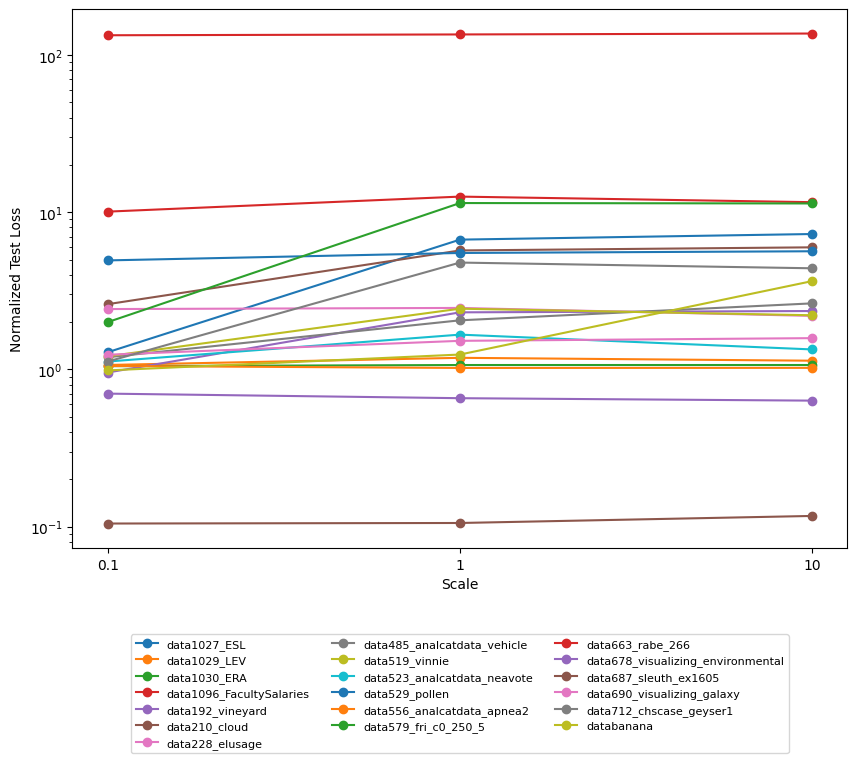

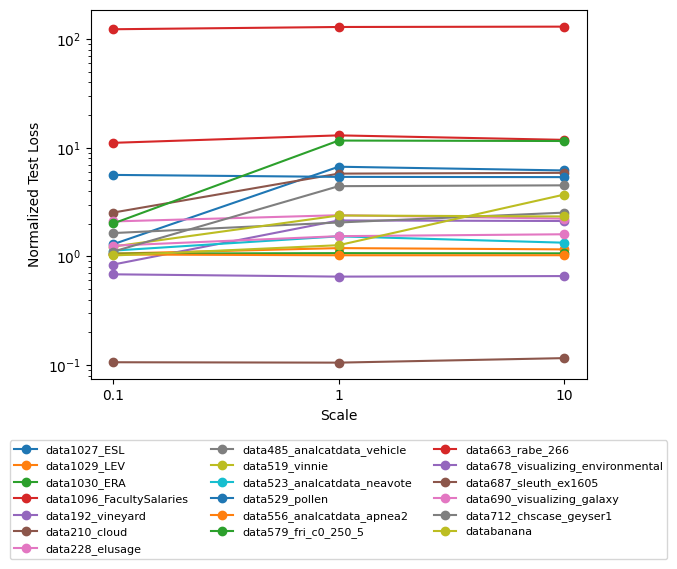

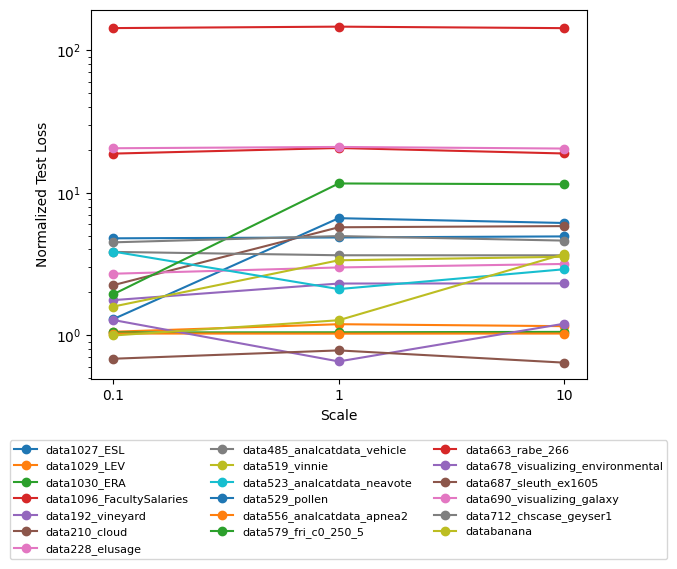

0.1    43
1       7
10      7
dtype: int64


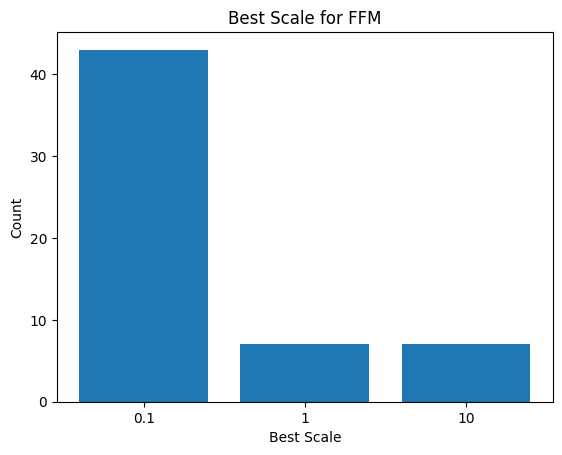

In [ ]:
experiments_df



normalized_ffn_experiments_df = experiments_df.copy()

for dataset_folder in normalized_ffn_experiments_df.index:
    mlp_result = normalized_ffn_experiments_df.loc[dataset_folder, "mlp_0.001"]
    normalized_ffn_experiments_df.loc[dataset_folder] = normalized_ffn_experiments_df.loc[dataset_folder] / mlp_result



## only keep the methods which start with "ffn"

ffn_experiments_df = normalized_ffn_experiments_df[[method for method in method_names if method.startswith("ffn")]]

## the column name is ffn_{scale}_{learning_rate}
## on the x axis we want to have the scale and on the y axis the value. The method should be the a single line 
## separate the df into 3 dfs based on the learning rate


## normalize the results by the mlp result for each dataset


plt.figure(figsize=(10,7))

scales = ["0.1", "1", "10"]


best_scales = []

for idx, lr in enumerate(["0.01", "0.001", "0.0001"]):
    lr_df = ffn_experiments_df[[method for method in ffn_experiments_df.columns if lr in method]]

    ## pick n random rows

    ## plot the reach row as a line plot with the scale on the x axis and the value on the y axis
    ## the x axis should only contain discrete values for the scale also add dots for the values



    for i, row in lr_df.iterrows():
        plt.plot([scales.index(method.split("_")[1]) for method in lr_df.columns], row, label=i, marker="o")


    plt.xticks(range(len(scales)), scales)

    plt.yscale("log")
    plt.xlabel("Scale")

    plt.ylabel("Normalized Test Loss")

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3,prop={'size': 8})

    plt.savefig(f'../../../assets/ffm_hyperparamter_sweep_full_dataset_{lr.replace(".","_")}.pdf', format="pdf", bbox_inches='tight')

    plt.show()


    ### plot in a bar chart the for which scale the method performed best how often

    best_scale = lr_df.idxmin(axis=1).value_counts()
    best_scale = best_scale.rename(lambda x: x.split("_")[1])

    best_scales.append(best_scale)


best_scale = pd.concat(best_scales, axis=1).sum(axis=1)

## order by scale

best_scale = best_scale.sort_index()

print(best_scale)


plt.bar(best_scale.index, best_scale)
plt.xlabel("Best Scale")
plt.ylabel("Count")
plt.title(f"Best Scale for FFM")
plt.savefig(f'../../../assets/ffm_best_scale_full_dataset.pdf', format="pdf", bbox_inches='tight')

plt.show()




